Accuracy: 82.75%
Time Running: 3340.67 seconds
Metrics for each label:
Label 0: Precision=0.74, Recall=0.68, F1=0.71
Label 1: Precision=0.86, Recall=0.89, F1=0.88


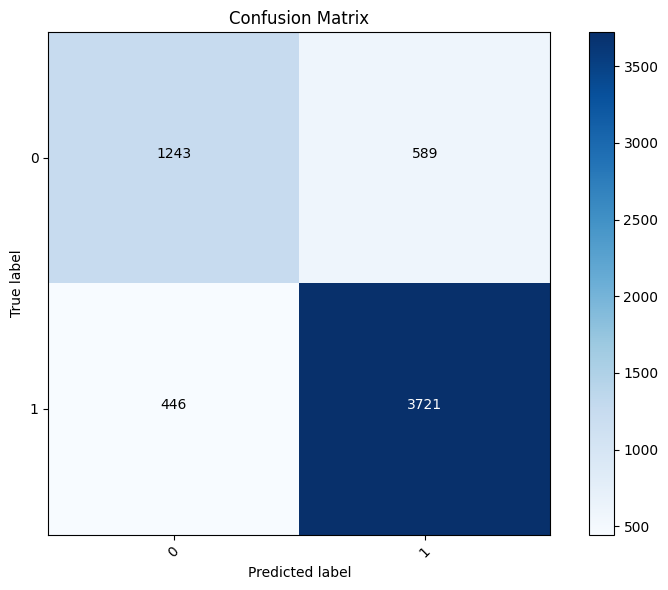

In [1]:
from pyspark.sql import SparkSession
from math import sqrt
from collections import Counter, defaultdict
import time
import numpy as np
import matplotlib.pyplot as plt

# 1. Khởi tạo Spark Session
spark = SparkSession.builder.appName("KNN_Spark_Distributed").getOrCreate()
sc = spark.sparkContext

# 2. Đọc dữ liệu từ file CSV và chuyển thành RDD
df = spark.read.csv('Hotel_KNN.csv', header=True, inferSchema=True)
data = df.rdd.map(lambda row: (tuple(row[:-1]), row[-1]))  # (features, label)

# 3. Chia dữ liệu thành train và test
train_rdd, test_rdd = data.randomSplit([0.8, 0.2], seed=42)

# 4. Hàm tính khoảng cách Euclidean
def euclidean_distance(point1, point2):
    return sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)))

# 5. Tính khoảng cách giữa từng điểm test và train
cartesian_rdd = test_rdd.cartesian(train_rdd)
distances_rdd = cartesian_rdd.map(lambda pair: (pair[0], (euclidean_distance(pair[0][0], pair[1][0]), pair[1][1])))

# 6. Nhóm khoảng cách theo điểm test và tìm k lân cận gần nhất
k = 5
k_nearest_rdd = distances_rdd.groupByKey().mapValues(
    lambda distances: sorted(distances, key=lambda x: x[0])[:k]
)

# 7. Dự đoán nhãn cho mỗi điểm test
predictions_rdd = k_nearest_rdd.mapValues(
    lambda neighbors: Counter([label for _, label in neighbors]).most_common(1)[0][0]
).map(lambda x: (x[0][1], x[1]))  # (actual_label, predicted_label)

# 8. Tính Accuracy
start_time = time.time()
correct_predictions = predictions_rdd.filter(lambda x: x[0] == x[1]).count()
total_predictions = predictions_rdd.count()
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

# 9. Tính ma trận nhầm lẫn
confusion_matrix_rdd = predictions_rdd.map(lambda x: ((x[0], x[1]), 1))
confusion_matrix = confusion_matrix_rdd.reduceByKey(lambda x, y: x + y).collect()

# Chuyển confusion matrix thành ma trận
labels = sorted(set(df.select(df.columns[-1]).rdd.flatMap(lambda x: x).collect()))
label_to_index = {label: i for i, label in enumerate(labels)}
conf_matrix_np = np.zeros((len(labels), len(labels)), dtype=int)

for (actual, predicted), count in confusion_matrix:
    conf_matrix_np[label_to_index[actual], label_to_index[predicted]] += count

# 10. Tính Precision, Recall, và F1
metrics = defaultdict(dict)
for i, label in enumerate(labels):
    tp = conf_matrix_np[i, i]
    fp = conf_matrix_np[:, i].sum() - tp
    fn = conf_matrix_np[i, :].sum() - tp
    tn = conf_matrix_np.sum() - (tp + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    metrics[label]['Precision'] = precision
    metrics[label]['Recall'] = recall
    metrics[label]['F1'] = f1

# 11. Hiển thị kết quả
runtime = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Time Running: {runtime:.2f} seconds")
print("Metrics for each label:")
for label, metric in metrics.items():
    print(f"Label {label}: Precision={metric['Precision']:.2f}, Recall={metric['Recall']:.2f}, F1={metric['F1']:.2f}")

# 12. Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_np, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Ghi số liệu vào từng ô
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(conf_matrix_np[i, j]), horizontalalignment="center",
                 color="white" if conf_matrix_np[i, j] > conf_matrix_np.max() / 2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# 13. Dừng Spark
spark.stop()
